In [20]:
import pandas as pd

In [21]:
def load_data(months):
    base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"
    data_frames = []

    for month in months:
        url = f"{base_url}{month}.parquet"
        df = pd.read_parquet(url)
        data_frames.append(df)
    
    data = pd.concat(data_frames)
    return data


In [22]:
def clean_data(data):
    data = data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
    data = data[data['trip_duration'] > 0]
    data = data[(data['trip_distance'] > 0) & (data['trip_distance'] < 100)]
    data = data[(data['trip_duration'] < 1440)]
    return data


In [23]:
months = ['2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02']
data = load_data(months)
cleaned_data = clean_data(data)
cleaned_data.to_parquet('cleaned_data.parquet')
print("Data ingestion and cleaning completed, and saved to 'cleaned_data.parquet'")


Data ingestion and cleaning completed, and saved to 'cleaned_data.parquet'


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
data = pd.read_parquet('cleaned_data.parquet')


Data Summary:
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.853059e+07                    18530592                    18530592   
mean   1.760710e+00  2023-11-30 17:37:49.561642  2023-11-30 17:55:28.795727   
min    1.000000e+00         2002-12-31 22:16:54         2002-12-31 23:05:41   
25%    2.000000e+00  2023-10-18 16:31:06.750000         2023-10-18 16:53:50   
50%    2.000000e+00         2023-11-30 01:38:00  2023-11-30 01:53:22.500000   
75%    2.000000e+00  2024-01-14 14:24:25.250000  2024-01-14 14:39:49.250000   
max    6.000000e+00         2024-03-01 00:01:37         2024-03-01 23:24:42   
std    4.292415e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.788344e+07   1.853059e+07  1.788344e+07  1.853059e+07   
mean      1.359169e+00   3.409104e+00  1.786612e+00  1.656456e+02   
min       0.000000e+00   1.000000e-02  1.000000e+00  1.000000e+00  

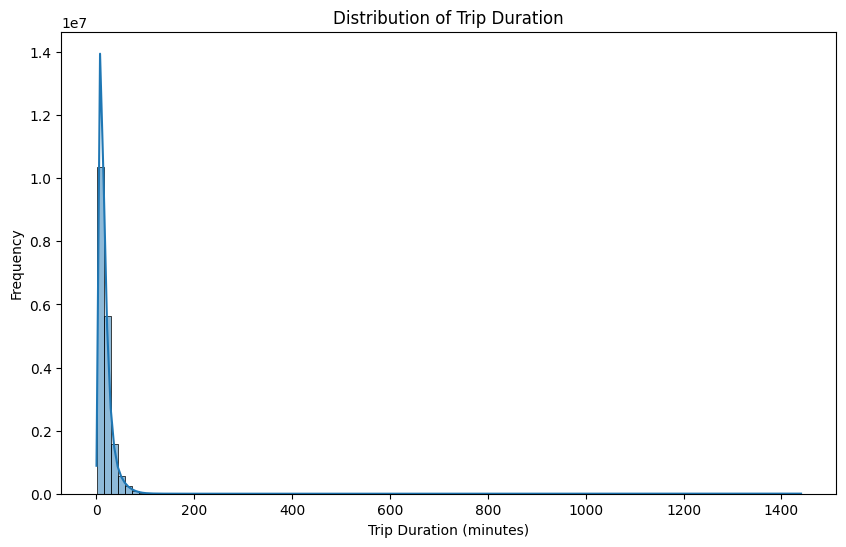

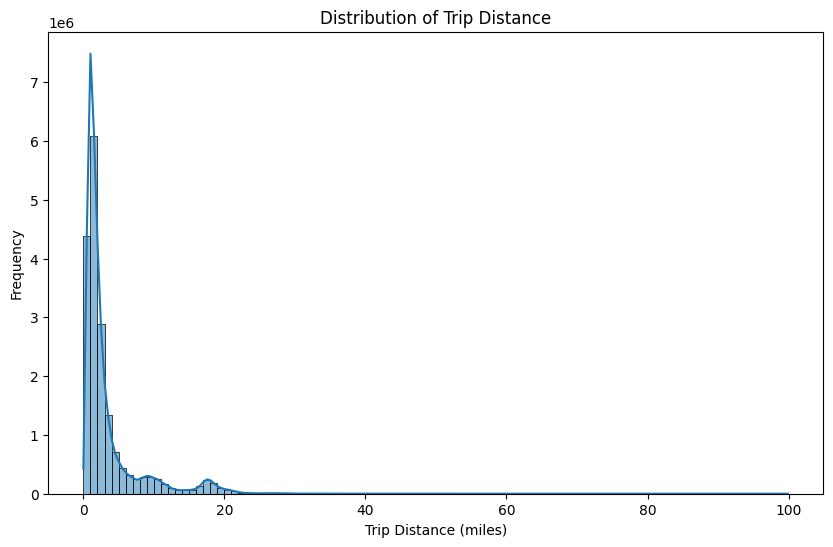

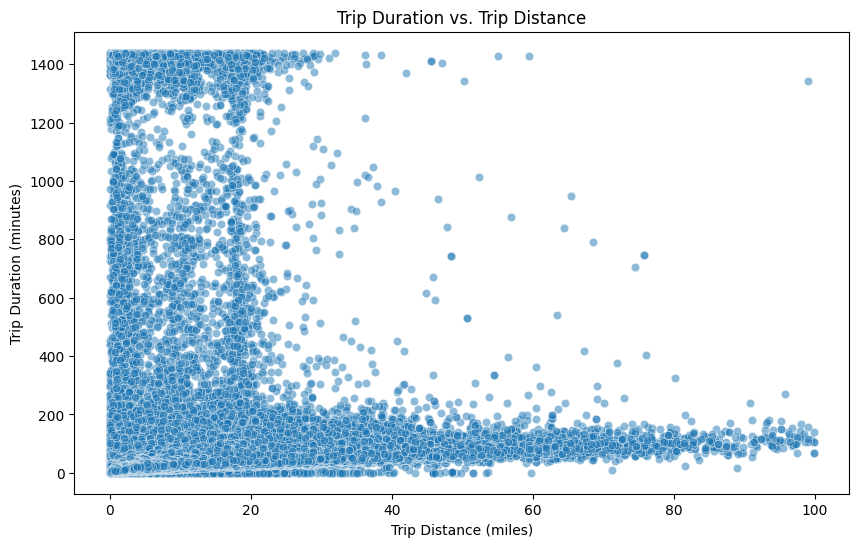

In [7]:
print("Data Summary:")
print(data.describe())

print("\nNull Values:")
print(data.isnull().sum())

plt.figure(figsize=(10, 6))
sns.histplot(data['trip_duration'], bins=100, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['trip_distance'], bins=100, kde=True)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='trip_duration', data=data, alpha=0.5)
plt.title('Trip Duration vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Duration (minutes)')
plt.show()


In [26]:
def calculate_monthly_average(data):
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
    return data.groupby(data['tpep_pickup_datetime'].dt.to_period('M'))['trip_duration'].mean()

def calculate_rolling_average(data):
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Sort by pickup datetime
    data = data.sort_values(by='tpep_pickup_datetime')

    data.set_index('tpep_pickup_datetime', inplace=True)
    rolling_avg = data['trip_duration'].rolling(window='45D').mean()
    data.reset_index(inplace=True)
    
    return rolling_avg




In [27]:
def visualize_monthly_average(monthly_avg):
    monthly_avg.plot(kind='bar', figsize=(10, 6), title="Average Trip Length per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Trip Length (minutes)")
    plt.show()

def visualize_rolling_average(rolling_avg):
    rolling_avg.plot(figsize=(10, 6), title="45-Day Rolling Average Trip Length")
    plt.xlabel("Date")
    plt.ylabel("Average Trip Length (minutes)")
    plt.show()


Monthly Average Trip Length:
tpep_pickup_datetime
2002-12    585.933333
2008-12    454.272222
2009-01    159.351852
2023-08     18.895370
2023-09     18.912585
2023-10     18.430947
2023-11     18.285736
2023-12     18.290704
2024-01     15.712969
2024-02     16.082524
2024-03     15.241667
Freq: M, Name: trip_duration, dtype: float64


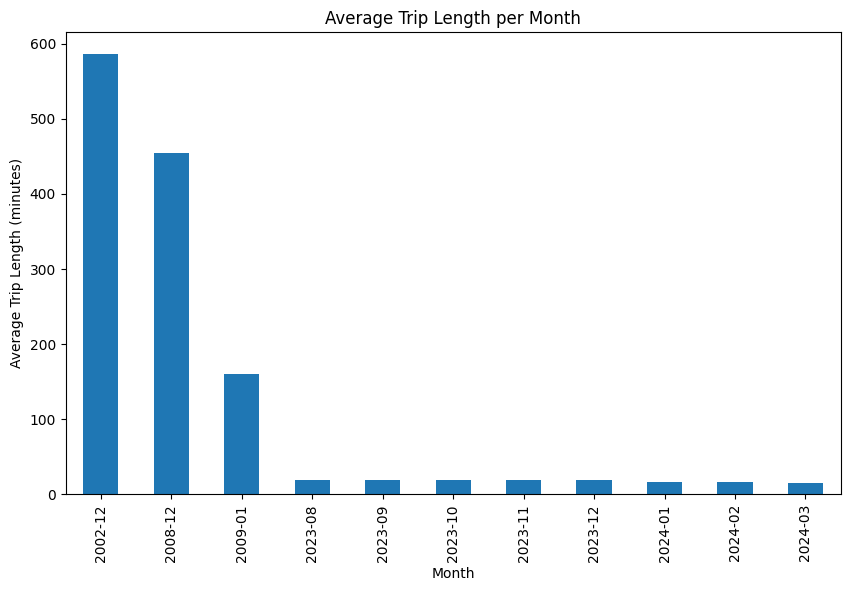

45-Day Rolling Average Trip Length:
tpep_pickup_datetime
2002-12-31 22:16:54    1005.233333
2002-12-31 22:59:39     505.633333
2002-12-31 22:59:39     339.100000
2002-12-31 23:03:18     585.933333
2008-12-31 15:05:04      73.000000
                          ...     
2024-02-29 23:59:58      15.983516
2024-02-29 23:59:58      15.983515
2024-02-29 23:59:58      15.983512
2024-03-01 00:01:23      15.983487
2024-03-01 00:01:37      15.983486
Name: trip_duration, Length: 18530592, dtype: float64


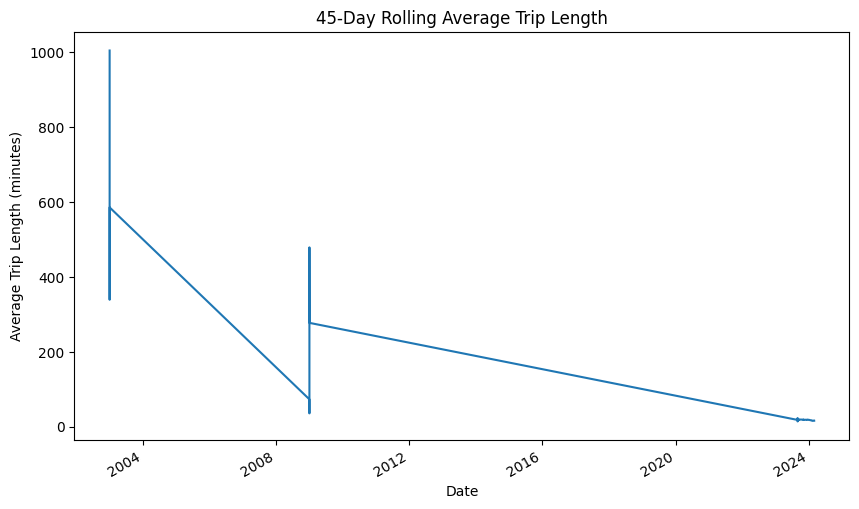

In [28]:
monthly_avg = calculate_monthly_average(data)
print("Monthly Average Trip Length:")
print(monthly_avg)
visualize_monthly_average(monthly_avg)

rolling_avg = calculate_rolling_average(data)
print("45-Day Rolling Average Trip Length:")
print(rolling_avg)
visualize_rolling_average(rolling_avg)
